In [1]:
import tqdm

In [2]:
%load_ext autoreload
%autoreload 1
%aimport library
from library import *

In [3]:
if False:
    from qiskit_ibm_provider import IBMProvider
    try:
        provider = IBMProvider()#hub='ibm-q')
    except:
        print("you need to save the API Token of your IBMQ-Account first")
        print("use `IBMProvider.save_account(token=<INSERT_IBM_QUANTUM_TOKEN>)` once")
        raise


# time evolution operator

In [4]:
from qiskit.quantum_info.operators import Operator
from scipy.linalg import expm
from copy import deepcopy

def create_time_evolution_gate_from_hamiltonian(H, dt):
    """
    H is given in units of hbar/s
    dt in s

    #TODO make it more performant by accepting H in form of a combination of Pauli matrices
    """
    N_qubits = np.log2(H.shape[0])
    assert N_qubits % 1 == 0, "shape of H is not of form 2^n."
    N_qubits = int(N_qubits)
    time_evolution_op = Operator(expm(-1j*H*dt))
    
    qc = QuantumCircuit(N_qubits, name='W')
    qc.unitary(time_evolution_op, range(N_qubits))
    return qc.to_instruction()
    

In [5]:
T=1
V=1

# |0> entspricht nicht vorhanden.
c0 = np.kron(np.eye(2), np.array([[0,0,],[1,0]]))
c1 = np.kron(np.array([[0,0,],[1,0]]), np.eye(2))
n0 = c0.T.conj() @ c0
n1 = c1.T.conj() @ c1
print(c0)
print(c1)
print(n0)
print(n1)
H = T * (c1.T.conj() @ c0 + c1 @ c0.T.conj()) + V * n1 @ n0
print(H)
W = create_time_evolution_gate_from_hamiltonian(H, .01)
print(get_matrix_for_gate(W, {}).to_matrix())

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
[[1.-0.01j 0.+0.j   0.+0.j   0.+0.j  ]
 [0.+0.j   1.+0.j   0.-0.01j 0.+0.j  ]
 [0.+0.j   0.-0.01j 1.+0.j   0.+0.j  ]
 [0.+0.j   0.+0.j   0.+0.j   1.+0.j  ]]


### steps of time evolution:

you need a translation invariant hamiltonian that consists of sums of hermitian operators that span over only two lattice sites / qubits.
you need a MPS matrix with a corresponding gate U that depends on some parameters.

- choose some new parameters for U to check
- find corresponding Vs or R and L
- estimate overlap
- choose better new parameters and repeat.


R


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/qiskit/visualization/circuit/qcstyle.py:315: UserWarning: style option/s (usepiformat, latexdrawerstyle) is/are not supported
  set_style(current_style, json_style)


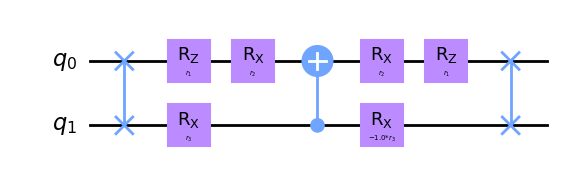

R^*


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/qiskit/visualization/circuit/qcstyle.py:315: UserWarning: style option/s (usepiformat, latexdrawerstyle) is/are not supported
  set_style(current_style, json_style)


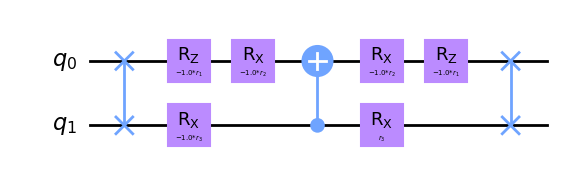

L


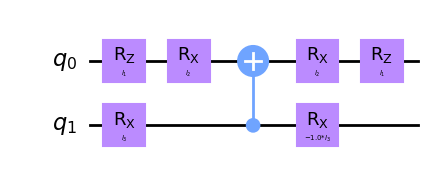

L^*


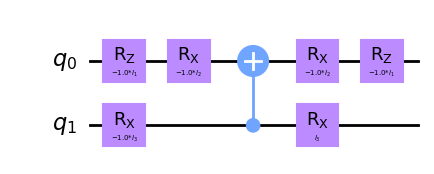

In [6]:
def create_mixed_env_circuit(params, name):
    qc = QuantumCircuit(2, name=name)
    if name=="R":
        qc.swap(0,1)
    qc.rz(params[0], 0)
    qc.rx(params[1], 0)
    
    qc.rx(params[2], 1)
    qc.cx(1,0)
    qc.rx(-params[2], 1)
    
    qc.rx(params[1], 0)
    qc.rz(params[0], 0)
    if name == "R":
        qc.swap(0,1)
    print(name)
    display(qc.draw())
    return qc.to_instruction()

def create_conjugated_mixed_env_circuit(params, name):
    """
    conjugating the whole matrix can be done by conjugating each gate.
    This means changing the sign for rx and rz while leaving it the same for ry.
    """
    qc = QuantumCircuit(2, name=name)
    if name[0]=="R":
        qc.swap(0,1)
    qc.rz(-params[0], 0)
    qc.rx(-params[1], 0)
    
    qc.rx(-params[2], 1)
    qc.cx(1,0)
    qc.rx(params[2], 1)
    
    qc.rx(-params[1], 0)
    qc.rz(-params[0], 0)
    if name[0] == "R":
        qc.swap(0,1)
    print(name)
    display(qc.draw())
    return qc.to_instruction()

# qiskit seems to internaly remember some things if we don't delete them first. otherwise it leads to unexpected behaviour.
# also there seems to be a weird connection between parameter names and Operator names. we get different results if Gate R is called "r".
try:
    del R, L, R_params, L_params
except:
    pass
R_params = Parameter("$r_1$"), Parameter("$r_2$"), Parameter("$r_3$")
R = create_mixed_env_circuit(R_params, "R")
R_conj = create_conjugated_mixed_env_circuit(R_params, "R^*")

L_params = Parameter("$l_1$"), Parameter("$l_2$"), Parameter("$l_3$")
L = create_mixed_env_circuit(L_params, "L")
L_conj = create_conjugated_mixed_env_circuit(L_params, "L^*")

In [7]:
# TODO wouldn't R and L have the same parameters since they have the same optimization criterion? excepet for having the bits flipped? That would explain why they only talk about R's representation in the paper.
# nope because the tranfer matrix is not hermitian. The circuits are probably just wrong. (missing some inverse and conjugation signs maybe?)

In [8]:
R_params_mapping = dict(zip(R_params, [1,1,1]))
R_mat = np.array(get_matrix_for_gate(R,R_params_mapping, 20))[::2,::2] # select part of matrix such that qubit 0 is 0 at input and output.
np.abs((R_mat * R_mat.conj()).sum())**2 / 4

0.41726857314283383

In [9]:
L_params_mapping = dict(zip(L_params, [1,1,1]))
L_mat = np.array(get_matrix_for_gate(L,L_params_mapping, 20))[:2,:2] # select part of matrix such that qubit 1 is 0 at input and output.
np.abs((L_mat * L_mat.conj()).sum())**2 / 4

0.41726857314283383

In [10]:
R_mat

array([[0.06207773-0.45464871j, 0.12418786-0.64805985j],
       [0.12418786-0.64805985j, 0.38757745+0.24564775j]])

In [11]:
__ = np.array(get_matrix_for_gate(R,R_params_mapping, 3))
__

array([[ 0.062-0.455j, -0.   -0.421j,  0.124-0.648j, -0.354+0.227j],
       [ 0.   +0.421j, -0.478-0.455j,  0.354-0.227j,  0.416-0.193j],
       [ 0.124-0.648j, -0.354+0.227j,  0.388+0.246j,  0.383+0.175j],
       [ 0.354-0.227j,  0.416-0.193j, -0.383-0.175j,  0.612-0.246j]])

In [12]:
_ = np.array(get_matrix_for_gate(R_conj,R_params_mapping, 3)).conj()
_

array([[ 0.062-0.455j, -0.   -0.421j,  0.124-0.648j, -0.354+0.227j],
       [ 0.   +0.421j, -0.478-0.455j,  0.354-0.227j,  0.416-0.193j],
       [ 0.124-0.648j, -0.354+0.227j,  0.388+0.246j,  0.383+0.175j],
       [ 0.354-0.227j,  0.416-0.193j, -0.383-0.175j,  0.612-0.246j]])

In [13]:
__-_ #should be all 0

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

# create circuits for optimizing L and R as given in https://www.nature.com/articles/s41534-021-00420-3

note that the swap gates are on the other side each because the order of qubits for L is inversed here


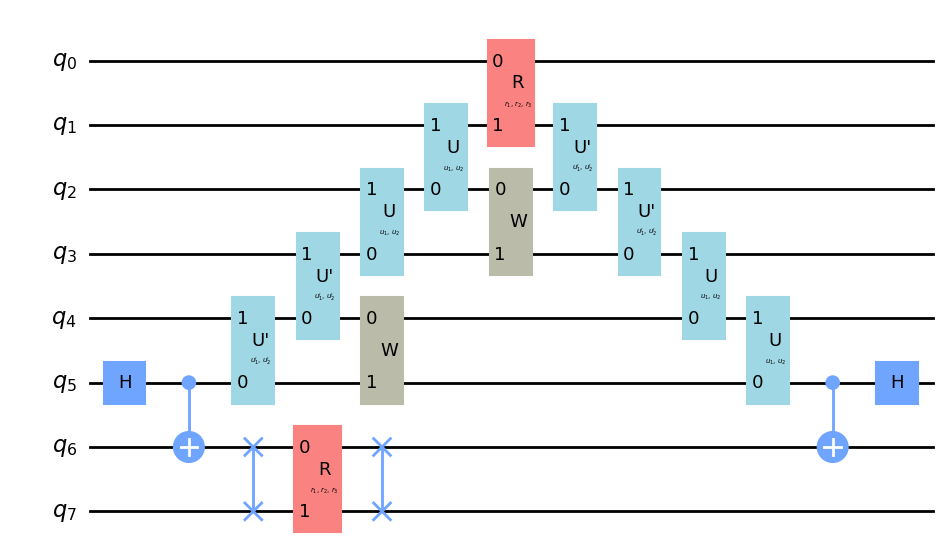

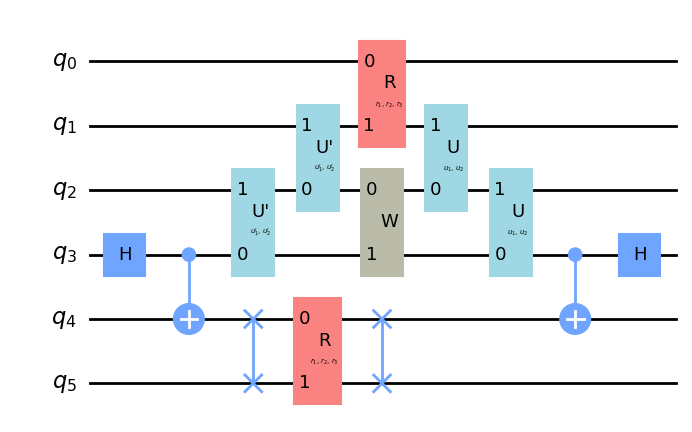

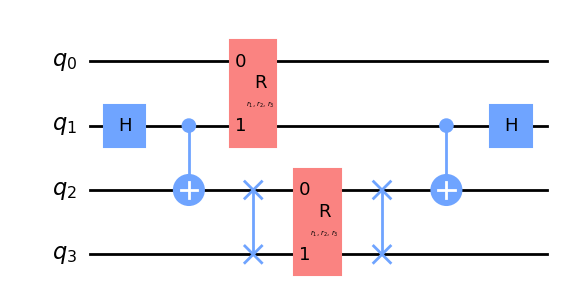

In [14]:
#del estimate_l_circuits, estimate_r_circuits as in the time evolution paper
use_inverse = False # wether to use inverses of U (False for the original paper)
use_env_conj = False # wether to use conjugate of L and R (False for the original paper)

# first create the circuits to optimize the environments L and R.
estimate_l_circuits = [(QuantumCircuit(length), factor) for length, factor in ((8,1), (6,-2), (4,1))]

# create the gates needed
U_params = Parameter("$u_1$"), Parameter("$u_2$")
U = generate_MPS_U_gate(*U_params)
new_U_params = Parameter("$u_1'$"), Parameter("$u_2'$")
U_ = generate_MPS_U_gate(*new_U_params)
U_.name = "U'"



# apply all gates that are shared with estimate_r_circuits
for i in range(3):
    qc = estimate_l_circuits[i][0]
    N = qc.num_qubits # should be 8-2i
    qc.h(N-3)
    qc.cnot(N-3, N-2)

    if i < 2:
        if use_inverse:
            qc.append(U_.inverse(),[N-3, N-4])
            qc.append(U_.inverse(),[N-4, N-5])
        else:
            qc.append(U_,[N-3, N-4])
            qc.append(U_,[N-4, N-5])
    if i==0:
        qc.append(U,[N-5, N-6])
        qc.append(U,[N-6,N-7])

estimate_r_circuits = deepcopy(estimate_l_circuits)

# apply the differing gates for r and l:
for i in range(3):
    qc_l = estimate_l_circuits[i][0]
    qc_r = estimate_r_circuits[i][0]
    N = qc_l.num_qubits # should be 8-2i

    qc_r.swap(N-1,N-2)
    qc_l.swap(0,1)

    qc_l.append(L, [0,1])
    if use_env_conj:
        qc_l.append(L_conj, [N-2, N-1])
        qc_r.append(R_conj, [0,1])
    else:
        qc_l.append(L, [N-2, N-1])
        qc_r.append(R, [0,1])

    qc_r.append(R, [N-2, N-1])

    for qc in (qc_r, qc_l):
        if i<2:
            qc.append(W, [N-4,N-3])
        if i == 0:
            qc.append(W, [2,3])
    
    qc_r.swap(N-1,N-2)
    qc_l.swap(0,1)

# apply the reversed MPS like structure
for i in range(3):
    for qc in (estimate_l_circuits[i][0], estimate_r_circuits[i][0]):
        N = qc.num_qubits

        # TODO vermutlich eigentlich invertieren. Aber mal gucken. können es so ja mal ausprobieren...
        if i==0:
            if use_inverse:
                qc.append(U_.inverse(),[N-6,N-7])
                qc.append(U_.inverse(),[N-5, N-6])
            else:
                qc.append(U_,[N-6,N-7])
                qc.append(U_,[N-5, N-6])
        if i < 2:
            qc.append(U,[N-4, N-5])
            qc.append(U,[N-3, N-4])
        
        qc.cnot(N-3, N-2)
        qc.h(N-3)
print("note that the swap gates are on the other side each because the order of qubits for L is inversed here")
for qc, _ in estimate_r_circuits:
    display(qc.draw())

In [15]:
resulting_state = np.array(get_matrix_for_gate(estimate_r_circuits[2][0], R_params_mapping, 20))[:,0]
print("resulting_state:", resulting_state, sep="\n")
print("resulting probabilities:", np.abs(resulting_state)**2, sep="\n")
print("all 0s:", np.abs(resulting_state[0])**2)

resulting_state:
[-4.61048114e-01-9.39783681e-02j -6.03428162e-02-3.25527964e-01j
 -1.46362636e-01-1.23431091e-01j  1.48276940e-01+9.39783681e-02j
 -7.96034176e-02-3.17358856e-01j  1.11683433e-01+5.11127667e-02j
 -2.77600000e-17+5.55100000e-17j  3.54036709e-01-7.28600000e-17j
 -6.03428162e-02-3.25527964e-01j  4.30099101e-02-9.39783681e-02j
  1.48276940e-01+9.39783681e-02j -1.46362636e-01-6.69839662e-02j
  1.11683433e-01+5.11127667e-02j -7.96034176e-02+1.73936641e-01j
 -3.54036709e-01+6.24500000e-17j -3.46900000e-17+0.00000000e+00j]
resulting probabilities:
[2.21397297e-01 1.09609711e-01 3.66572555e-02 3.08179847e-02
 1.07053347e-01 1.50857041e-02 3.85197770e-33 1.25341991e-01
 1.09609711e-01 1.06817860e-02 3.08179847e-02 2.59088731e-02
 1.50857041e-02 3.65906591e-02 1.25341991e-01 1.20339610e-33]
all 0s: 0.2213972970967946


# testing these circuits:

In [16]:
assert use_inverse == False and use_env_conj == False, "warning: the created circuits are not the ones defined in the original paper!"

In [17]:
def get_cost_function(circuits, old_U_param_values, new_U_param_values):
    def cost_function(params):
        was_list = True
        if type(params) not in (list, tuple):
            params = [params]
            was_list = False
        params = [{**dict([*zip(new_U_params, new_U_param_values),
                       *zip(U_params,     old_U_param_values)
                      ]),
                  **params_
                 } for params_ in params]
        res = estimate_0_string_amplitude_and_add_up(circuits, params, seed=4)
        if was_list:
            return res
        return res[0]
    return cost_function

In [18]:
from library.optimization_tools import minimize
from numpy.random import random

In [19]:
def l(L, params, precission=20):
    unitaries = get_matrix_for_gate(L, params, precission)
    if type(unitaries) == list:
        return [unitary.to_matrix()[:2,:2].flatten() for unitary in unitaries]
    return unitaries.to_matrix()[:2,:2].flatten()
    
def r(R, params, precission=20):
    unitaries = get_matrix_for_gate(R, params, precission)
    if type(unitaries) == list:
        return [unitary.to_matrix()[::2,::2].flatten() for unitary in unitaries]
    return unitaries.to_matrix()[::2,::2].flatten()


In [20]:
print("the below optimial value should be 0 not -0.52")
np.random.seed(10)
U_param_values = [1,2]
V = QuantumCircuit(2) # won't be used anyway.
U_param_values_ = [1,2]
ketMPS = iMPS(V,U,U_param_values)
braMPS = iMPS(V,U,U_param_values_)
cost_func = get_cost_function(estimate_l_circuits, U_param_values, U_param_values_)

cost_func([dict(zip(L.params, np.random.random(3)*2*np.pi))])
params = minimize(cost_func, dict(zip(L.params, np.random.random(3)*2*np.pi)), desired_minimum=0, is_noisy=False)


the below optimial value should be 0 not -0.52


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.5244020075605507
        x: [ 3.922e+00 -9.540e-02  6.090e-04]
      nit: 29
      jac: [-1.738e+00  1.685e-01 -2.405e-03]
 hess_inv: [[ 3.682e-03  3.826e-02 -2.902e-02]
            [ 3.826e-02  3.978e-01 -2.729e-01]
            [-2.902e-02 -2.729e-01  5.555e+00]]
     nfev: 295
     njev: 71
========warning: desired_minimum: 0 not reached: end value is -0.5244020075605507, method used: BFGS.None


In [21]:
l(L, params)

array([-7.07106842e-01+0.70066188j,  9.22989939e-08+0.09525047j,
        9.22989938e-08+0.09525047j, -7.07106830e-01-0.7006619j ])

In [22]:
# can't use eigh because transfer matrix is not hermitian.
from scipy.linalg import eig

In [23]:

transfer_matrix = get_transfer_matrix(ketMPS, braMPS, W)

In [24]:
eig_val, left_eig_val = eig(transfer_matrix, left=True, right=False)

In [25]:
eig_val

array([ 9.99986875e-01-0.00138609j,  1.90774689e-02-0.0094838j ,
       -4.97968664e-03+0.01051185j,  1.43384443e-32-0.00294658j])

In [26]:
# check values from scipy. everything here should be very small.
left_eig_val.T.conj() @ transfer_matrix - left_eig_val.T.conj()*eig_val[:,None]

array([[-1.11022302e-16-4.77048956e-18j,  2.12613740e-17-2.16840434e-19j,
        -3.74812079e-18-2.16840434e-19j,  0.00000000e+00+1.38777878e-17j],
       [-1.08420217e-16+9.12898229e-17j, -1.21972744e-19+8.67361738e-19j,
         2.71050543e-19+1.51788304e-18j, -1.73472348e-16-8.67361738e-18j],
       [ 3.28730099e-16-1.59160879e-16j, -5.42101086e-19+1.30104261e-18j,
         8.13151629e-19+1.08420217e-18j, -1.56125113e-17-6.59194921e-17j],
       [-1.15725706e-15+3.45129067e-18j,  1.20625692e-18+1.30104261e-18j,
         9.54926126e-19-1.30104261e-18j, -1.66287351e-16-1.87501345e-17j]])

In [27]:
largest_eigenvalue_index = np.argmax(np.abs(eig_val))
left_environment = left_eig_val[:,largest_eigenvalue_index]
print(left_environment)

# if the optimization would have worked the following should be near 0 everywhere.
left_environment-l(L, params)

[ 7.07117264e-01+0.j         -3.95268747e-06-0.00133788j
 -3.95268747e-06-0.00133788j  7.07091411e-01+0.00182526j]


array([ 1.41422411e+00-0.70066188j, -4.04498646e-06-0.09658835j,
       -4.04498646e-06-0.09658835j,  1.41419824e+00+0.70248715j])

## quantifying the error

In [28]:
# run it many times to get average error and standard deviation
errors = []
U_params_ket = []
U_params_bra = []
L_params_list = []
l_vectors_circuit = []
l_vectors_scipy = []
for seed in tqdm(range(20)):
    np.random.seed(seed)
    V = QuantumCircuit(2) # won't be used anyway. just needed to define an iMPS object.
    U_param_values = random(2)*2*np.pi
    U_param_values_ = U_param_values + random(2)/100
    ketMPS = iMPS(V,U,U_param_values)
    braMPS = iMPS(V,U,U_param_values_)
    
    cost_func = get_cost_function(estimate_l_circuits, U_param_values, U_param_values_)
    params = minimize(cost_func, dict(zip(L.params, np.random.random(3)*2*np.pi)), desired_minimum=0, is_noisy=False)
    l_vector = np.abs(l(L, params)) # using abs because phase is badly defined for eigenvectors.
    
    transfer_matrix = get_transfer_matrix(ketMPS, braMPS, W)
    eig_val, left_eig_val = eig(transfer_matrix, left=True, right=False)
    largest_eigenvalue_index = np.argmax(np.abs(eig_val))
    if not eig_val[largest_eigenvalue_index] > 1-1e-2:
        print("eigenvalue too small", U_params_values, U_params_values_)
    left_environment = np.abs(left_eig_val[:,largest_eigenvalue_index])
    print(left_environment)
    
    errors.append(left_environment/left_environment.sum() -l_vector/l_vector.sum() )
    U_params_ket.append(U_param_values)
    U_params_bra.append(U_param_values_)
    L_params_list.append(params)
    l_vectors_circuit.append(l_vector)
    l_vectors_scipy.append(left_environment)
    print(errors[-1])

  0%|                                                                                                                                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.06964815444345965
        x: [ 2.068e+00  6.283e+00  4.863e+00]
      nit: 36
      jac: [-6.781e-02 -3.545e-02  7.565e-01]
 hess_inv: [[ 2.169e-06 -1.454e-06  1.026e-06]
            [-1.454e-06  1.005e-06 -6.959e-07]
            [ 1.026e-06 -6.959e-07  4.916e-07]]
     nfev: 372
     njev: 90
========warning: desired_minimum: 0 not reached: end value is -0.06964815444345965, method used: BFGS.None
  5%|██████████████                                                                                                      

[7.07208462e-01 2.28994106e-04 2.34530355e-04 7.07005010e-01]
[ 0.21231724 -0.21224729 -0.21224337  0.21217342]
negative value in estimate 0 strings!!! This value can't be negative: [-6.9388939e-18]
negative value in estimate 0 strings!!! This value can't be negative: [-1.38777878e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-5.55111512e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-2.77555756e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-2.77555756e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-2.77555756e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-1.38777878e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-2.77555756e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-2.77555756e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-1.38777878e-17]
negative 

========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.3291253591870061
        x: [ 2.547e+00  5.735e+00  6.283e+00]
      nit: 91
      jac: [ 1.342e+00  1.184e+00 -5.588e-08]
 hess_inv: [[ 8.651e-07 -9.376e-07 -7.460e-08]
            [-9.376e-07  1.022e-06  7.534e-08]
            [-7.460e-08  7.534e-08  4.388e-08]]
     nfev: 832
     njev: 205
========warning: desired_minimum: 0 not reached: end value is -0.3291253591870061, method used: BFGS.None
 10%|████████████████████████████                                                                                                                                                                                                                                                            | 2/20 [00:19<03:04, 10.24s/it]

negative value in estimate 0 strings!!! This value can't be negative: [-1.38777878e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-5.55111512e-17]
negative value in estimate 0 strings!!! This value can't be negative: [-2.77555756e-17]
[7.07148171e-01 2.11191291e-04 2.16494938e-04 7.07065324e-01]
[ 0.18942726 -0.18939985 -0.1893961   0.1893687 ]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.7094813878099886
        x: [ 2.375e+00  6.473e+00  6.283e+00]
      nit: 31
      jac: [ 1.307e+00 -2.807e-01  1.852e-04]
 hess_inv: [[ 1.434e-06 -1.434e-06  1.197e-04]
            [-1.434e-06  1.434e-06 -1.197e-04]
            [ 1.197e-04 -1.197e-04  1.001e-02]]
     nfev: 472
     njev: 115
========warning: desired_minimum: 0 not reached: end value is -0.7094813878099886, method used: BFGS.None
 15%|██████████████████████████████████████████                                                                                                                                                                                                                                              | 3/20 [00:27<02:35,  9.14s/it]

[0.70709454 0.00231291 0.00227044 0.7071116 ]
[ 0.07887803 -0.07886907 -0.07889901  0.07889005]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.07034246215830649
        x: [ 2.051e+00  6.283e+00  4.851e+00]
      nit: 26
      jac: [-1.071e-01  1.936e-01  1.999e-01]
 hess_inv: [[ 5.122e-02 -9.998e-04  3.419e-02]
            [-9.998e-04  2.197e-05 -6.677e-04]
            [ 3.419e-02 -6.677e-04  2.283e-02]]
     nfev: 273
     njev: 66
========warning: desired_minimum: 0 not reached: end value is -0.07034246215830649, method used: BFGS.None
 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 4/20 [00:31<01:55,  7.21s/it]

[7.07136655e-01 3.12449495e-04 3.17400660e-04 7.07076766e-01]
[ 0.21517359 -0.21515418 -0.21515068  0.21513126]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.717693409609132
        x: [ 2.359e+00  6.215e+00  6.284e+00]
      nit: 71
      jac: [ 1.110e+00  8.504e-02  3.450e-04]
 hess_inv: [[ 3.708e-05 -6.630e-04 -1.570e-03]
            [-6.630e-04  1.215e-02  2.905e-02]
            [-1.570e-03  2.905e-02  8.805e-02]]
     nfev: 672
     njev: 165
========warning: desired_minimum: 0 not reached: end value is -0.717693409609132, method used: BFGS.None
 25%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 5/20 [00:41<02:05,  8.37s/it]

[0.70709908 0.00122179 0.00115698 0.70711248]
[ 0.03118867 -0.03117053 -0.03121627  0.03119813]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.565174671947201
        x: [ 2.454e+00  5.868e+00  6.283e+00]
      nit: 29
      jac: [ 1.406e+00  7.609e-01  5.954e-03]
 hess_inv: [[ 4.152e-06 -2.347e-06 -1.616e-03]
            [-2.347e-06  2.704e-06  9.616e-04]
            [-1.616e-03  9.616e-04  6.375e-01]]
     nfev: 484
     njev: 116
========warning: desired_minimum: 0 not reached: end value is -0.565174671947201, method used: BFGS.None
 30%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 6/20 [00:49<01:55,  8.26s/it]

[0.70709788 0.00288119 0.00281121 0.70710423]
[ 0.15086695 -0.15084454 -0.15089382  0.15087142]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.724436411628243
        x: [ 2.988e+00  5.510e+00  6.283e+00]
      nit: 88
      jac: [ 2.069e-01  1.309e+00  7.857e-03]
 hess_inv: [[ 5.270e-06 -1.007e-06 -1.678e-06]
            [-1.007e-06  3.816e-07  8.197e-08]
            [-1.678e-06  8.197e-08  8.707e-07]]
     nfev: 698
     njev: 172
========warning: desired_minimum: 0 not reached: end value is -0.724436411628243, method used: BFGS.None
 35%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 7/20 [01:02<02:07,  9.79s/it]

[0.70713263 0.00200963 0.0019944  0.70707526]
[ 0.24561649 -0.24559089 -0.24560164  0.24557604]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.2844058272302644
        x: [ 2.562e+00  6.847e+00  6.282e+00]
      nit: 142
      jac: [-2.386e-01  2.497e-01  1.631e-03]
 hess_inv: [[ 3.824e-01  3.950e-01 -2.754e+00]
            [ 3.950e-01  4.081e-01 -2.845e+00]
            [-2.754e+00 -2.845e+00  1.990e+01]]
     nfev: 948
     njev: 234
========warning: desired_minimum: 0 not reached: end value is -0.2844058272302644, method used: BFGS.None
 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 8/20 [01:19<02:22, 11.88s/it]

[7.07139518e-01 1.84536124e-04 1.72434900e-04 7.07073997e-01]
[ 0.19365746 -0.19363002 -0.19363857  0.19361114]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.7042063817691516
        x: [ 2.631e+00  6.909e+00  6.283e+00]
      nit: 78
      jac: [-1.461e+00  1.857e+00  2.006e-02]
 hess_inv: [[ 1.519e+00  1.192e+00  1.319e+00]
            [ 1.192e+00  9.351e-01  1.035e+00]
            [ 1.319e+00  1.035e+00  1.150e+00]]
     nfev: 558
     njev: 137
========warning: desired_minimum: 0 not reached: end value is -0.7042063817691516, method used: BFGS.None
 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 9/20 [01:28<02:01, 11.08s/it]

[0.7071001  0.00412145 0.00404331 0.70708989]
[ 0.20689951 -0.20686846 -0.20692339  0.20689234]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.703871206718161
        x: [ 2.358e+00  6.230e+00  6.281e+00]
      nit: 65
      jac: [-2.429e+00 -1.266e-01  5.940e-04]
 hess_inv: [[ 6.698e-04 -1.279e-02 -3.055e-02]
            [-1.279e-02  2.442e-01  5.829e-01]
            [-3.055e-02  5.829e-01  1.762e+00]]
     nfev: 616
     njev: 151
========warning: desired_minimum: 0 not reached: end value is -0.703871206718161, method used: BFGS.None
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 10/20 [01:39<01:49, 10.99s/it]

[7.07093117e-01 4.59773940e-04 4.94868966e-04 7.07120122e-01]
[ 0.02513354 -0.02515548 -0.02513068  0.02515262]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.0034739898500941485
        x: [ 1.794e+00  6.283e+00  4.738e+00]
      nit: 24
      jac: [-1.993e-01 -9.153e-03  8.353e-01]
 hess_inv: [[ 1.677e-07 -7.382e-08 -9.963e-08]
            [-7.382e-08  3.999e-08  4.838e-08]
            [-9.963e-08  4.838e-08  6.194e-08]]
     nfev: 383
     njev: 93
========warning: desired_minimum: 0 not reached: end value is -0.0034739898500941485, method used: BFGS.None
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 11/20 [01:46<01:27,  9.74s/it]

[7.07098900e-01 6.88434615e-05 2.72471385e-05 7.07114659e-01]
[ 0.2434893  -0.24348017 -0.24350958  0.24350044]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.07531776829693229
        x: [ 2.110e+00  6.283e+00  4.898e+00]
      nit: 33
      jac: [ 1.767e-01  2.872e-01 -1.292e-01]
 hess_inv: [[ 5.085e-01 -4.568e-02  4.248e-01]
            [-4.568e-02  4.110e-03 -3.816e-02]
            [ 4.248e-01 -3.816e-02  3.548e-01]]
     nfev: 311
     njev: 75
========warning: desired_minimum: 0 not reached: end value is -0.07531776829693229, method used: BFGS.None
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 12/20 [01:51<01:08,  8.50s/it]

[0.70709568 0.00335068 0.00342504 0.70710165]
[ 0.20142414 -0.20145241 -0.20140007  0.20142834]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.7124927873535442
        x: [ 2.445e+00  6.680e+00  6.283e+00]
      nit: 38
      jac: [ 1.156e+00 -5.099e-01  7.743e-02]
 hess_inv: [[ 5.951e-09  2.007e-09 -2.218e-10]
            [ 2.007e-09  6.867e-10 -5.679e-11]
            [-2.218e-10 -5.679e-11  8.727e-10]]
     nfev: 474
     njev: 116
========warning: desired_minimum: 0 not reached: end value is -0.7124927873535442, method used: BFGS.None
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 13/20 [02:00<00:59,  8.48s/it]

[7.07120218e-01 2.86169988e-04 3.11915732e-04 7.07093217e-01]
[ 0.14750514 -0.1475047  -0.1474865   0.14748606]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.718079711432716
        x: [ 3.925e+00  6.350e+00  6.282e+00]
      nit: 80
      jac: [ 4.807e-01  5.715e-02  2.379e-02]
 hess_inv: [[ 2.866e-07 -1.558e-06  2.205e-06]
            [-1.558e-06  8.471e-06 -1.199e-05]
            [ 2.205e-06 -1.199e-05  1.697e-05]]
     nfev: 845
     njev: 209
========warning: desired_minimum: 0 not reached: end value is -0.718079711432716, method used: BFGS.None
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 14/20 [02:15<01:03, 10.52s/it]

[7.07119553e-01 4.61455735e-04 5.27915952e-04 7.07093662e-01]
[ 0.03098467 -0.030999   -0.03095204  0.03096637]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.015102320321727179
        x: [ 2.226e+00  6.283e+00  5.046e+00]
      nit: 127
      jac: [ 4.146e-01 -2.928e-01 -2.359e-01]
 hess_inv: [[ 2.285e-01 -1.386e-03  3.996e-01]
            [-1.386e-03  1.347e-05 -2.420e-03]
            [ 3.996e-01 -2.420e-03  6.988e-01]]
     nfev: 768
     njev: 189
========warning: desired_minimum: 0 not reached: end value is -0.015102320321727179, method used: BFGS.None
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 15/20 [02:28<00:56, 11.25s/it]

[7.05537856e-01 4.81764578e-06 6.07301735e-06 7.08672233e-01]
[ 0.16701276 -0.16812137 -0.16812048  0.16922909]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.47511637684087704
        x: [ 2.364e+00  6.161e+00  6.282e+00]
      nit: 51
      jac: [ 9.037e-01  1.011e-01  6.713e-03]
 hess_inv: [[ 2.867e-03 -2.390e-02  6.324e-06]
            [-2.390e-02  1.992e-01 -5.283e-05]
            [ 6.324e-06 -5.283e-05  8.472e-07]]
     nfev: 608
     njev: 149
========warning: desired_minimum: 0 not reached: end value is -0.47511637684087704, method used: BFGS.None
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 16/20 [02:38<00:43, 10.99s/it]

[0.70711457 0.00118797 0.00120558 0.70709697]
[ 0.05386773 -0.05386774 -0.0538553   0.05385531]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.0556599830992359
        x: [ 2.134e+00  6.283e+00  4.922e+00]
      nit: 39
      jac: [ 2.533e-01 -2.504e-01 -2.235e-01]
 hess_inv: [[ 2.454e-02  6.315e-04  2.497e-02]
            [ 6.315e-04  1.751e-05  6.427e-04]
            [ 2.497e-02  6.427e-04  2.541e-02]]
     nfev: 461
     njev: 113
========warning: desired_minimum: 0 not reached: end value is -0.0556599830992359, method used: BFGS.None
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 17/20 [02:46<00:29,  9.90s/it]

[0.70710006 0.00209006 0.00213132 0.7071072 ]
[ 0.19657867 -0.19659573 -0.19656665  0.19658371]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.0847488652362786
        x: [ 2.548e+00  6.832e+00  6.283e+00]
      nit: 238
      jac: [-1.371e+00  1.197e+00  8.245e-04]
 hess_inv: [[ 1.377e-01  1.636e-01 -3.106e-02]
            [ 1.636e-01  1.947e-01 -3.603e-02]
            [-3.106e-02 -3.603e-02  9.877e-01]]
     nfev: 1456
     njev: 362
========warning: desired_minimum: 0 not reached: end value is -0.0847488652362786, method used: BFGS.None
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18/20 [03:09<00:27, 13.93s/it]

[7.07099733e-01 6.01851006e-04 5.84373714e-04 7.07113332e-01]
[ 0.18931509 -0.18931372 -0.18932606  0.18932469]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.5774581171128167
        x: [ 2.654e+00  5.641e+00  6.283e+00]
      nit: 53
      jac: [ 5.137e-01  7.998e-01  1.040e-01]
 hess_inv: [[ 1.269e-10  3.650e-10 -5.370e-11]
            [ 3.650e-10  1.055e-09 -1.555e-10]
            [-5.370e-11 -1.555e-10  2.295e-11]]
     nfev: 740
     njev: 180
========warning: desired_minimum: 0 not reached: end value is -0.5774581171128167, method used: BFGS.None
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 19/20 [03:21<00:13, 13.32s/it]

[0.70710883 0.00347251 0.00354306 0.70708733]
[ 0.21158186 -0.21159912 -0.21154948  0.21156674]


========warning: BFGS did not converge.None
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.503710834785123
        x: [ 2.602e+00  6.885e+00  6.283e+00]
      nit: 43
      jac: [ 5.136e-01 -2.671e-01  3.193e-02]
 hess_inv: [[ 1.717e-09 -4.783e-09  9.529e-10]
            [-4.783e-09  1.332e-08 -2.654e-09]
            [ 9.529e-10 -2.654e-09  5.323e-10]]
     nfev: 503
     njev: 125
========warning: desired_minimum: 0 not reached: end value is -0.503710834785123, method used: BFGS.None
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.47s/it]

[7.07147531e-01 1.51727728e-04 1.48396131e-04 7.07065997e-01]
[ 0.20344434 -0.20341434 -0.20341669  0.2033867 ]


In [29]:
np.mean(np.abs(errors)), np.std(errors)

(0.15976387459700775, 0.17504115555343402)

In [30]:
import json
class jsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, Parameter):
            return obj.__repr__()
        return JSONEncoder.default(self, obj)

with open("results/check_convergence_for_finding_the_environment/with_paper_circuits.json", "w") as f:
    json.dump({
        'errors': errors,
        'U_params_ket': U_params_ket,
        'U_params_bra': U_params_bra,
        'L_params': [{str(key): value for key, value in param.items()} for param in L_params_list],
        'l_vectors_circuit': l_vectors_circuit,
        'l_vectors_scipy': l_vectors_scipy
    }, f, cls=jsonEncoder)

In [31]:
errors

[array([ 0.21231724, -0.21224729, -0.21224337,  0.21217342]),
 array([ 0.18942726, -0.18939985, -0.1893961 ,  0.1893687 ]),
 array([ 0.07887803, -0.07886907, -0.07889901,  0.07889005]),
 array([ 0.21517359, -0.21515418, -0.21515068,  0.21513126]),
 array([ 0.03118867, -0.03117053, -0.03121627,  0.03119813]),
 array([ 0.15086695, -0.15084454, -0.15089382,  0.15087142]),
 array([ 0.24561649, -0.24559089, -0.24560164,  0.24557604]),
 array([ 0.19365746, -0.19363002, -0.19363857,  0.19361114]),
 array([ 0.20689951, -0.20686846, -0.20692339,  0.20689234]),
 array([ 0.02513354, -0.02515548, -0.02513068,  0.02515262]),
 array([ 0.2434893 , -0.24348017, -0.24350958,  0.24350044]),
 array([ 0.20142414, -0.20145241, -0.20140007,  0.20142834]),
 array([ 0.14750514, -0.1475047 , -0.1474865 ,  0.14748606]),
 array([ 0.03098467, -0.030999  , -0.03095204,  0.03096637]),
 array([ 0.16701276, -0.16812137, -0.16812048,  0.16922909]),
 array([ 0.05386773, -0.05386774, -0.0538553 ,  0.05385531]),
 array([

similar tests with my own circuits come below.

# create own circuits

In [33]:
params_ = dict(zip(U_params, [2,2]))
# the 1j* does not matter since it is a global phase.
np.array(get_matrix_for_gate(U, params_)) +1j*np.array(get_matrix_for_gate(complex_conjugate_instruction(U), params_)).conj()

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/qiskit/visualization/circuit/qcstyle.py:315: UserWarning: style option/s (usepiformat, latexdrawerstyle) is/are not supported
  set_style(current_style, json_style)


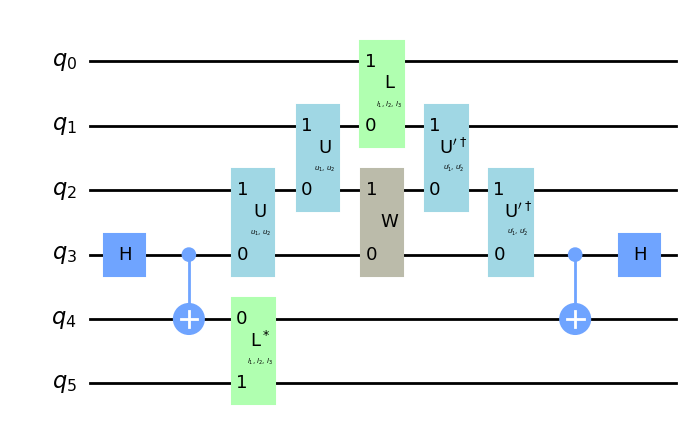

In [34]:
qc = QuantumCircuit(6)
U_conj = complex_conjugate_instruction(U)
U_conj_ = complex_conjugate_instruction(U_)
W_conj = complex_conjugate_instruction(W)


N = qc.num_qubits # should be 8-2i
qc.h(3)
qc.cnot(3, 4)

qc.append(U, [3,2])
qc.append(U, [2,1])

qc.append(L, [1,0])
qc.append(W, [3,2])
qc.append(L_conj, [4,5])

qc.append(U_.inverse(), [2,1])
qc.append(U_.inverse(), [3,2])

qc.cnot(3,4)
qc.h(3)
estimate_l_circuits[1] = (qc, -2)
display(qc.draw())

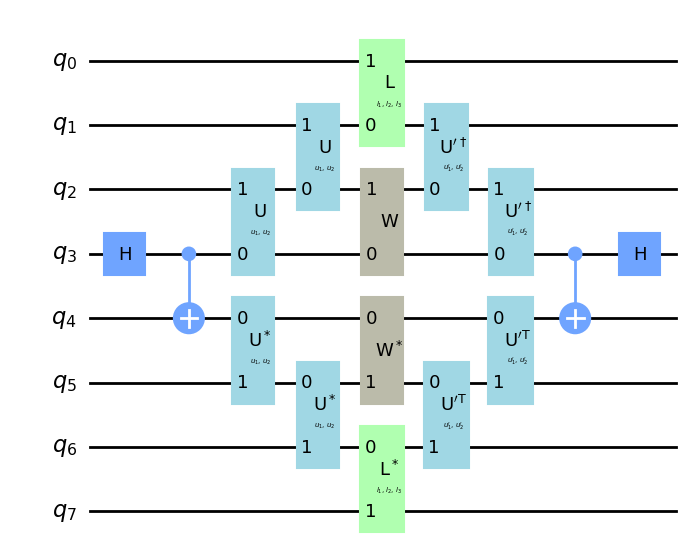

In [35]:
qc = QuantumCircuit(8)
U_conj = complex_conjugate_instruction(U)
U_conj_ = complex_conjugate_instruction(U_)
W_conj = complex_conjugate_instruction(W)


N = qc.num_qubits # should be 8-2i
qc.h(3)
qc.cnot(3, 4)

qc.append(U, [3,2])
qc.append(U, [2,1])
qc.append(U_conj, [4,5])
qc.append(U_conj, [5,6])

qc.append(L, [1,0])
qc.append(W, [3,2])
qc.append(W_conj, [4,5])
qc.append(L_conj, [6,7])

qc.append(U_.inverse(), [2,1])
qc.append(U_.inverse(), [3,2])
qc.append(U_conj_.inverse(), [5,6])
qc.append(U_conj_.inverse(), [4,5])

qc.cnot(3,4)
qc.h(3)
estimate_l_circuits[0] = (qc, 1)
display(qc.draw())

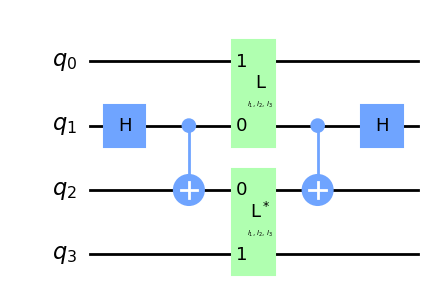

array([0.41726857])

In [38]:
qc = QuantumCircuit(4)


N = qc.num_qubits # should be 8-2i
qc.h(1)
qc.cnot(1,2)

qc.append(L, [1,0])
qc.append(L_conj, [2,3])

qc.cnot(1,2)
qc.h(1)
estimate_l_circuits[2] = (qc, 1)

display(estimate_l_circuits[2][0].draw())
L_params_mapping = dict(zip(L_params, [1,1,1]))
estimate_0_strings_prob(estimate_l_circuits[2][0].bind_parameters(L_params_mapping))

# compute average difference between optimized l and exact l with my circuits:
the following is the exact same code as used for the tests of the time evolution paper.

note that these circuits use inverted env and U! Because that is how I think they can and should work.

In [40]:
# run it many times to get average error and standard deviation
errors = []
U_params_ket = []
U_params_bra = []
L_params_list = []
l_vectors_circuit = []
l_vectors_scipy = []
for seed in tqdm(range(20)):
    np.random.seed(seed)
    V = QuantumCircuit(2) # won't be used anyway. just needed to define an iMPS object.
    U_param_values = random(2)*2*np.pi
    U_param_values_ = U_param_values + random(2)/100
    ketMPS = iMPS(V,U,U_param_values)
    braMPS = iMPS(V,U,U_param_values_)
    
    cost_func = get_cost_function(estimate_l_circuits, U_param_values, U_param_values_)
    params = minimize(cost_func, dict(zip(L.params, np.random.random(3)*2*np.pi)), desired_minimum=0, is_noisy=False)
    l_vector = np.abs(l(L, params)) # using abs because phase is badly defined for eigenvectors.
    
    transfer_matrix = get_transfer_matrix(ketMPS, braMPS, W)
    eig_val, left_eig_val = eig(transfer_matrix, left=True, right=False)
    largest_eigenvalue_index = np.argmax(np.abs(eig_val))
    if not eig_val[largest_eigenvalue_index] > 1-1e-2:
        print("eigenvalue too small", U_params_values, U_params_values_)
    left_environment = np.abs(left_eig_val[:,largest_eigenvalue_index])
    print(left_environment)
    
    errors.append(left_environment/left_environment.sum() -l_vector/l_vector.sum() )
    U_params_ket.append(U_param_values)
    U_params_bra.append(U_param_values_)
    L_params_list.append(params)
    l_vectors_circuit.append(l_vector)
    l_vectors_scipy.append(left_environment)
    print(errors[-1])

  5%|██████████████                                                                                                                                                                                                                                                                          | 1/20 [00:11<03:39, 11.53s/it]

[7.07208462e-01 2.28994106e-04 2.34530355e-04 7.07005010e-01]
[ 7.38952419e-05 -3.94422514e-06 -3.07878482e-08 -6.99202289e-05]


========warning: desired_minimum: 0 not reached: end value is 4.352354698866634e-09, method used: BFGS.None
 10%|████████████████████████████                                                                                                                                                                                                                                                            | 2/20 [00:27<04:13, 14.08s/it]

[7.07148171e-01 2.11191291e-04 2.16494938e-04 7.07065324e-01]
[ 3.05488581e-05 -3.14139855e-06  6.07712899e-07 -2.80151725e-05]


========warning: desired_minimum: 0 not reached: end value is 2.6322714563598026e-08, method used: BFGS.None
 15%|██████████████████████████████████████████                                                                                                                                                                                                                                              | 3/20 [00:40<03:50, 13.56s/it]

[0.70709454 0.00231291 0.00227044 0.7071116 ]
[-3.81708247e-06  1.27732360e-05 -1.71632603e-05  8.20710680e-06]


========warning: desired_minimum: 0 not reached: end value is 6.975643962459088e-08, method used: BFGS.None
 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 4/20 [00:52<03:31, 13.19s/it]

[7.07136655e-01 3.12449495e-04 3.17400660e-04 7.07076766e-01]
[ 3.90666898e-05 -1.96516072e-05 -1.61521628e-05 -3.26291982e-06]


========warning: desired_minimum: 0 not reached: end value is 5.0530653328273445e-08, method used: BFGS.None
 25%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                  | 5/20 [01:06<03:19, 13.33s/it]

[0.70709908 0.00122179 0.00115698 0.70711248]
[ 2.71671050e-06  1.54252738e-05 -3.03200942e-05  1.21781098e-05]


========warning: desired_minimum: 0 not reached: end value is 2.2326411386330847e-08, method used: BFGS.None
 30%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 6/20 [01:20<03:08, 13.48s/it]

[0.70709788 0.00288119 0.00281121 0.70710423]
[-2.07954815e-07  2.26138191e-05 -2.66674787e-05  4.26161446e-06]


========warning: desired_minimum: 0 not reached: end value is 3.4049977282180066e-09, method used: BFGS.None
 35%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                      | 7/20 [01:33<02:54, 13.39s/it]

[0.70713263 0.00200963 0.0019944  0.70707526]
[ 1.99332518e-05  5.66340775e-06 -5.08007495e-06 -2.05165846e-05]


========warning: desired_minimum: 0 not reached: end value is 1.2900265522475252e-08, method used: BFGS.None
 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 8/20 [01:47<02:43, 13.66s/it]

[7.07139518e-01 1.84536124e-04 1.72434900e-04 7.07073997e-01]
[ 2.93496182e-05 -1.91301832e-06 -1.04677170e-05 -1.69688829e-05]


========warning: desired_minimum: 0 not reached: end value is 1.1798548804620168e-08, method used: BFGS.None
 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 9/20 [02:03<02:35, 14.18s/it]

[0.7071001  0.00412145 0.00404331 0.70708989]
[ 2.01947278e-06  2.90346125e-05 -2.58979673e-05 -5.15611802e-06]


========warning: desired_minimum: 0 not reached: end value is 8.710421162128057e-09, method used: BFGS.None
 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 10/20 [02:17<02:21, 14.18s/it]

[7.07093117e-01 4.59773940e-04 4.94868966e-04 7.07120122e-01]
[-7.88365310e-06 -1.40572273e-05  1.07419696e-05  1.11989108e-05]


========warning: desired_minimum: 0 not reached: end value is 5.225183463686278e-08, method used: BFGS.None
 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 11/20 [02:35<02:17, 15.29s/it]

[7.07098900e-01 6.88434615e-05 2.72471385e-05 7.07114659e-01]
[ 5.47256888e-05 -4.55915714e-05 -7.50026152e-05  6.58684979e-05]


========warning: desired_minimum: 0 not reached: end value is 1.0260220340008175e-08, method used: BFGS.None
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 12/20 [02:47<01:56, 14.54s/it]

[0.70709568 0.00335068 0.00342504 0.70710165]
[-4.41899233e-06 -2.38497924e-05  2.84847227e-05 -2.15938001e-07]


========warning: desired_minimum: 0 not reached: end value is 4.377614915007655e-08, method used: BFGS.None
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 13/20 [02:59<01:35, 13.63s/it]

[7.07120218e-01 2.86169988e-04 3.11915732e-04 7.07093217e-01]
[ 2.90268025e-05 -2.85832294e-05 -1.03859332e-05  9.94236009e-06]


========warning: desired_minimum: 0 not reached: end value is 1.7654138817491116e-08, method used: BFGS.None
 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 14/20 [03:12<01:20, 13.48s/it]

[7.07119553e-01 4.61455735e-04 5.27915952e-04 7.07093662e-01]
[ 9.51230920e-06 -2.38455253e-05  2.31161030e-05 -8.78288689e-06]


========warning: desired_minimum: 0 not reached: end value is 2.2091454388029064e-07, method used: BFGS.None
 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 15/20 [03:31<01:15, 15.10s/it]

[7.05537856e-01 4.81764578e-06 6.07301735e-06 7.08672233e-01]
[-1.05475059e-03 -5.38572311e-05 -5.29695540e-05  1.16157738e-03]


========warning: desired_minimum: 0 not reached: end value is 6.531231955264616e-08, method used: BFGS.None
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 16/20 [03:46<01:00, 15.17s/it]

[0.70711457 0.00118797 0.00120558 0.70709697]
[ 1.37181705e-05 -1.37224772e-05 -1.28568931e-06  1.28999607e-06]


========warning: desired_minimum: 0 not reached: end value is 5.339738051723941e-08, method used: BFGS.None
 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 17/20 [04:04<00:47, 15.93s/it]

[0.70710006 0.00209006 0.00213132 0.7071072 ]
[ 1.10936361e-06 -1.81720266e-05  1.09143280e-05  6.14833502e-06]


========warning: desired_minimum: 0 not reached: end value is 1.359092527408734e-08, method used: BFGS.None
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 18/20 [04:20<00:31, 15.97s/it]

[7.07099733e-01 6.01851006e-04 5.84373714e-04 7.07113332e-01]
[-6.68399892e-06  8.05420071e-06 -4.29375835e-06  2.92355656e-06]


========warning: desired_minimum: 0 not reached: end value is 1.5073541415056013e-08, method used: BFGS.None
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 19/20 [04:33<00:15, 15.13s/it]

[0.70710883 0.00347251 0.00354306 0.70708733]
[ 1.04713410e-05 -2.77310926e-05  2.19107307e-05 -4.65097911e-06]


========warning: desired_minimum: 0 not reached: end value is 1.1680997058505227e-08, method used: BFGS.None
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:46<00:00, 14.31s/it]

[7.07147531e-01 1.51727728e-04 1.48396131e-04 7.07065997e-01]
[ 3.55903283e-05 -5.59233542e-06 -7.94763007e-06 -2.20503628e-05]


In [41]:
np.mean(np.abs(errors)), np.std(errors)

(4.561549569179438e-05, 0.00017722965092327244)

In [42]:
import json
class jsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, Parameter):
            return obj.__repr__()
        return JSONEncoder.default(self, obj)

with open("results/check_convergence_for_finding_the_environment/with_my_circuits.json", "w") as f:
    json.dump({
        'errors': errors,
        'U_params_ket': U_params_ket,
        'U_params_bra': U_params_bra,
        'L_params': [{str(key): value for key, value in param.items()} for param in L_params_list],
        'l_vectors_circuit': l_vectors_circuit,
        'l_vectors_scipy': l_vectors_scipy
    }, f, cls=jsonEncoder)

In [43]:
errors

[array([ 7.38952419e-05, -3.94422514e-06, -3.07878482e-08, -6.99202289e-05]),
 array([ 3.05488581e-05, -3.14139855e-06,  6.07712899e-07, -2.80151725e-05]),
 array([-3.81708247e-06,  1.27732360e-05, -1.71632603e-05,  8.20710680e-06]),
 array([ 3.90666898e-05, -1.96516072e-05, -1.61521628e-05, -3.26291982e-06]),
 array([ 2.71671050e-06,  1.54252738e-05, -3.03200942e-05,  1.21781098e-05]),
 array([-2.07954815e-07,  2.26138191e-05, -2.66674787e-05,  4.26161446e-06]),
 array([ 1.99332518e-05,  5.66340775e-06, -5.08007495e-06, -2.05165846e-05]),
 array([ 2.93496182e-05, -1.91301832e-06, -1.04677170e-05, -1.69688829e-05]),
 array([ 2.01947278e-06,  2.90346125e-05, -2.58979673e-05, -5.15611802e-06]),
 array([-7.88365310e-06, -1.40572273e-05,  1.07419696e-05,  1.11989108e-05]),
 array([ 5.47256888e-05, -4.55915714e-05, -7.50026152e-05,  6.58684979e-05]),
 array([-4.41899233e-06, -2.38497924e-05,  2.84847227e-05, -2.15938001e-07]),
 array([ 2.90268025e-05, -2.85832294e-05, -1.03859332e-05,  9.94

# optimize mixed environment

In [24]:
# dt is used in W...
# sqrt for sinusoidality?

In [49]:
def get_cost_function(circuits, old_U_param_values, new_U_param_values):
    def cost_function(params):
        params = [{**dict([*zip(new_U_params, new_U_param_values),
                       *zip(U_params,     old_U_param_values)
                      ]),
                  **params_
                 } for params_ in params]
        return estimate_0_string_amplitude_and_add_up(circuits, params, seed=4)
    return cost_function
        
    

In [51]:
cost_func = get_cost_function(estimate_l_circuits, [1,1], [1, 1])


In [27]:
# the quantum cost function result doesn't need to fit perfectly because we use abs instead of Re(...) there.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 49.82it/s]


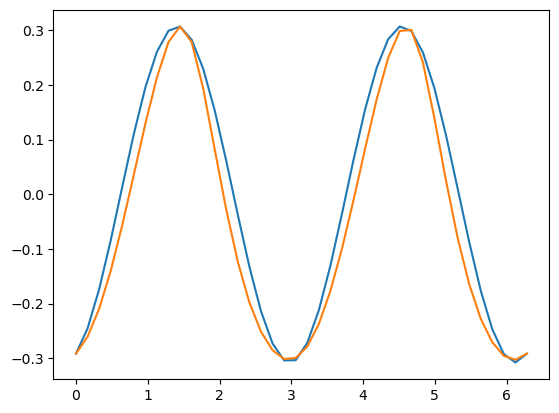

In [52]:
def func(theta):
    if type(theta) in [np.ndarray, list, tuple]:
        return np.real(cost_func([dict(zip(L_params, [1, theta_, 1])) for theta_ in theta]))
    else:
        return np.real(cost_func([dict(zip(L_params, [1, theta, 1]))]))[0]
args = get_double_sinusoidal_args(func)
N=40
theta_range = np.linspace(0, 2*np.pi, N)
template_result = double_sinosoid_template(theta_range, *args)
plt.plot(theta_range, template_result)
estimation_results = []
for i in tqdm(range(N)):
    estimation_results.append(func([theta_range[i]]))
estimation_results = np.array(estimation_results)
plt.plot(theta_range, estimation_results-estimation_results[0]+template_result[0])

/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


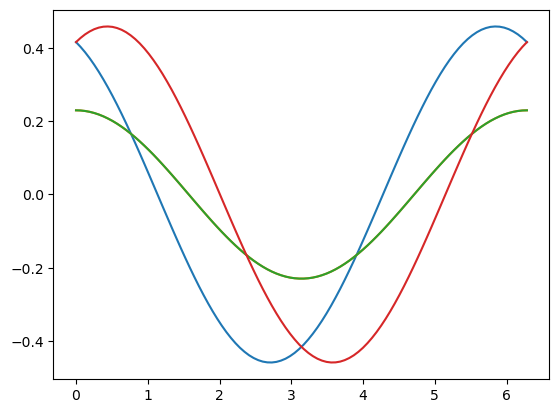

In [31]:
l_m = []
theta_range = np.linspace(0,2*np.pi, 100)
for theta in theta_range:
    L_mat = get_matrix_for_gate(L, dict(zip(L_params, [1, theta, 1]))).to_matrix()[:2, :2]
    l_m.append(L_mat.flatten())
plt.plot(np.linspace(0,2*np.pi, 100), l_m)

In [41]:
check_double_sinusoidality(func)

[{Parameter($l_1$): 1, Parameter($l_2$): 0, Parameter($l_3$): 1}, {Parameter($l_1$): 1, Parameter($l_2$): 3.141592653589793, Parameter($l_3$): 1}, {Parameter($l_1$): 1, Parameter($l_2$): 1.5707963267948966, Parameter($l_3$): 1}, {Parameter($l_1$): 1, Parameter($l_2$): -1.5707963267948966, Parameter($l_3$): 1}, {Parameter($l_1$): 1, Parameter($l_2$): 0.7853981633974483, Parameter($l_3$): 1}, {Parameter($l_1$): 1, Parameter($l_2$): -0.7853981633974483, Parameter($l_3$): 1}]
if sinusoidal, the args are: (0.30752051609972364, -1.2448525138629782, 3.3306690738754696e-16, 0.0)
[{Parameter($l_1$): 1, Parameter($l_2$): 0, Parameter($l_3$): 1}]
[{Parameter($l_1$): 1, Parameter($l_2$): 0.0, Parameter($l_3$): 1}]
[{Parameter($l_1$): 1, Parameter($l_2$): 0.06346651825433926, Parameter($l_3$): 1}]
[{Parameter($l_1$): 1, Parameter($l_2$): 0.06346651825433926, Parameter($l_3$): 1}]
[{Parameter($l_1$): 1, Parameter($l_2$): 0.06346651825433926, Parameter($l_3$): 1}]
theta: 0.06346651825433926, f1(theta

In [64]:
estimate = np.empty((10,10))
#cost_func = get_cost_function(estimate_r_circuits, [1,1], [1, 1])
for i in tqdm(range(10)):
    for j in range(10):
        estimate[i,j] = cost_func([dict(zip(L_params, (3,i/5*np.pi, j/5*np.pi)))])[0]



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.26it/s]


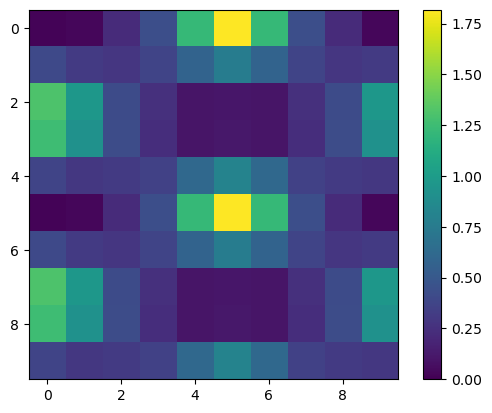

In [65]:
im = plt.imshow(estimate, vmin=0)
plt.colorbar(im)

In [ ]:
# this is the output from tensornetwork contraction.
# the abs term is probably the right way around.
im = plt.imshow(estimate/2)
plt.colorbar(im)

In [ ]:
# this is the output from tensornetwork contraction.
# the abs term is probably the wrong way around. so there might be minor changes to the qc simulated result.
im = plt.imshow(estimate/2)
plt.colorbar(im)

In [ ]:
estimate.min()

In [ ]:
estimate

In [ ]:
L_param_values = double_rotosolve(cost_func, dict(zip(L_params, [1,1,1])))
print(f"cost func at end: {cost_func(L_param_values)}")
L_param_values

In [ ]:
# model with hopping term. t=0.01 and flipped cx
cost func at end: 7.5142248983084414e-06

{Parameter($l_1$): 3.137561484202476,
 Parameter($l_2$): 1.5671988307611184,
 Parameter($l_3$): 3.141592653589591}

In [ ]:
# model with hopping term. t=0.01
cost func at end: 2.0683266138354917e-05

{Parameter($l_1$): 4.711039950528887,
 Parameter($l_2$): 3.207005820531522,
 Parameter($l_3$): 3.1415926535929874}

In [ ]:
mit [1,1] und dt = 0.00001
cost func at end: 4.999878289169146e-11

{Parameter($l_1$): 4.712388980384687,
 Parameter($l_2$): 3.2066688942950123,
 Parameter($l_3$): 3.141592655017136}

In [ ]:
[1,1] und dt = .01
cost func at end: 1.73197416609705e-05

{Parameter($l_1$): 1.5707963275887655,
 Parameter($l_2$): 3.1974306932254053,
 Parameter($l_3$): 3.1415926535925074}

In [ ]:
#für cz:
{Parameter($r_1$): 1.5707963276791719,
 Parameter($r_2$): 1.0415926534980788,
 Parameter($r_3$): 3.2828950822794116}

In [ ]:
cost_func(R_param_values)

In [ ]:
# todo normal optimize for quantum computable cost_func...

In [ ]:
new_U_param_values = [1,1]
old_U_param_values = [1,1]
Umat = get_matrix_for_gate(U, dict([*zip(U_params, old_U_param_values)]))
U_mat = get_matrix_for_gate(U_.inverse(), dict([*zip(new_U_params, new_U_param_values)]),)
Wmat = get_matrix_for_gate(W, {})

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_tensor_network(nodes):
    # Create a new NetworkX graph
    G = nx.Graph()

    # Add nodes to the graph
    for node in nodes:
        G.add_node(node.name)

    # Add edges to the graph
    for node in nodes:
        for edge in node.edges:
            if edge.node1 is not None and edge.node2 is not None:
                G.add_edge(edge.node1.name, edge.node2.name)
            elif edge.node1 is not None:
                G.add_edge(edge.node1.name, edge.node1.name)
            elif edge.node2 is not None:
                G.add_edge(edge.node2.name, edge.node2.name)

    # Draw the graph
    nx.draw(G, with_labels=True)
    plt.show()

In [ ]:
import tensornetwork as tn
Wnode = tn.Node(Wmat.to_matrix().reshape((2,)*4), name="W")
U_node = tn.Node(U_mat.to_matrix().reshape((2,)*4), name="U'")
U_node2 = tn.Node(U_mat.to_matrix().reshape((2,)*4), name="U'_2")
Unode = tn.Node(Umat.to_matrix().reshape((2,)*4), name="U")
Unode2 = tn.Node(Umat.to_matrix().reshape((2,)*4), name="U_2")

Nodes = [Wnode, U_node, U_node2, Unode, Unode2]

Unode[3] ^ Unode2[0]
Unode[2] ^ Wnode[0]
Unode2[2] ^ Wnode[1]
Wnode[3] ^ U_node2[0]
Wnode[2] ^ U_node[0]
U_node2[2] ^ U_node[1]
outward_dangling_edges = [Unode.edges[0], U_node[2]]
dangling_zero_edges = [Unode.edges[1], Unode2[1],  U_node.edges[3], U_node2.edges[3]]
inward_dangling_edges = [Unode2.edges[3], U_node2[1]]

In [ ]:
plot_tensor_network(Nodes)

In [ ]:
U_node2.edges

In [ ]:
E_UU = tn.contractors.greedy(Nodes, output_edge_order=[*outward_dangling_edges, *dangling_zero_edges, *inward_dangling_edges]).tensor[:,:,0,0,0,0,:,:].reshape((4,4))

In [ ]:
E_UU

In [ ]:
import tensornetwork as tn

L_eigenvalue_param_list = []
L_eigenvalue = []

def swap_q(x):
    x = np.swapaxes(x,0,1)
    return np.swapaxes(x, 2,3)
E_UU = 0
def get_cost_function(env_type, old_U_param_values, new_U_param_values):
    Umat = get_matrix_for_gate(U, dict([*zip(U_params, old_U_param_values)]), precission=20)
    U_mat = get_matrix_for_gate(U_.inverse(), dict([*zip(new_U_params, new_U_param_values)]), precission=20)
    Wmat = get_matrix_for_gate(W, {}, precission=20)

    Wnode = tn.Node(swap_q(Wmat.to_matrix().reshape((2,)*4)), name="W")
    U_node = tn.Node(swap_q(U_mat.to_matrix().reshape((2,)*4)), name="U'")
    U_node2 = tn.Node(swap_q(U_mat.to_matrix().reshape((2,)*4)), name="U'_2")
    Unode = tn.Node(swap_q(Umat.to_matrix().reshape((2,)*4)), name="U")
    Unode2 = tn.Node(swap_q(Umat.to_matrix().reshape((2,)*4)), name="U_2")
    
    Nodes = [Wnode, U_node, U_node2, Unode, Unode2]
    
    Unode[3] ^ Unode2[0]
    Unode[2] ^ Wnode[0]
    Unode2[2] ^ Wnode[1]
    Wnode[3] ^ U_node2[0]
    Wnode[2] ^ U_node[0]
    U_node2[2] ^ U_node[1]
    outward_dangling_edges = [Unode[0], U_node[2]]
    dangling_zero_edges = [Unode[1], Unode2[1],  U_node[3], U_node2[3]]
    inward_dangling_edges = [Unode2[3], U_node2[1]]

    global E_UU
    E_UU = tn.contractors.greedy(Nodes, output_edge_order=[*inward_dangling_edges, *dangling_zero_edges, *outward_dangling_edges]).tensor[:,:,0,0,0,0,:,:].reshape((4,4))
    if env_type == "R":
        def cost_function(params):
            r = get_matrix_for_gate(R, params, precission=20).to_matrix()[::2,::2].flatten()
            return (np.abs(E_UU @ r - r)**2).sum() / np.abs(r**2).sum() #(np.abs(E_UU @ r)**2).sum() + r.conj().T @ r - 2*np.abs(r.T.conj() @ E_UU @ r)  #
    if env_type == "L":
        def cost_function(params):
            #print(":: possibly still wrong")
            l = get_matrix_for_gate(L, params, precission=20).to_matrix()[:2,:2].flatten()
            return (np.abs(l @ E_UU - l)**2).sum() / np.abs(l**2).sum() # (np.abs(l @ E_UU)**2).sum() + np.real(l.conj().T @ l) - 2*np.abs(l @ E_UU @ l.T.conj())  #

    if env_type == "L eigenvalue":
        def cost_function(params):
            l = get_matrix_for_gate(L, params, precission=20).to_matrix()[:2,:2].flatten()
            ret = 1- np.sqrt( (np.abs(l@E_UU)**2).sum()/(np.abs(l)**2).sum() )
            #assert ret >= 0, f"Eigenvalue greater than 1: {1-ret}, params: {params}"
            L_eigenvalue.append(1-ret)
            L_eigenvalue_param_list.append(params)
            return ret
        
    return cost_function

In [ ]:
def l(L, params, precission=20):
    return get_matrix_for_gate(L, params, precission).to_matrix()[:2,:2].flatten()
def r(R, params, precission=20):
    return get_matrix_for_gate(R, params, precission).to_matrix()[::2,::2].flatten()

def l_norm(params):
    l = get_matrix_for_gate(L, params, precission=20).to_matrix()[:2,:2].flatten()
    return np.abs(l).sum()
def r_norm(params):
    r = get_matrix_for_gate(R, params, precission=20).to_matrix()[::2,::2].flatten()
    return np.abs(r).sum()

In [ ]:
a.extend([6,7])
a

In [ ]:
E_UU 

In [ ]:
# warum hat das jetzt funktioniert, obwohl ich nicht durch |l|**2 geteilt habe?
#L_param_values = [1.5707963276791719, 1.0415926534980788, 3.2828950822794116]
l = get_matrix_for_gate(L, L_param_values, precission=3).to_matrix()[:2,:2].flatten()
print(l)
print(l @ E_UU)
print(l @ E_UU  - l)

In [ ]:
# warum hat das jetzt funktioniert, obwohl ich nicht durch |l|**2 geteilt habe?
#L_param_values = [1.5707963276791719, 1.0415926534980788, 3.2828950822794116]
l = get_matrix_for_gate(L, L_param_values, precission=3).to_matrix()[:2,:2].flatten()
print(l)
print(l @ E_UU)
print(l @ E_UU  - l)

In [ ]:
r = get_matrix_for_gate(R, R_param_values, precission=3).to_matrix()[:2,:2].flatten()
print(r)
print(E_UU @ r)
print(E_UU @ r -r)

In [ ]:
r.conj().T @ E_UU

In [ ]:
np.trace(r.reshape((2,2)))

In [ ]:
cost_func = get_cost_function("R", [1,1], [1,1])

In [ ]:
cost_func = get_cost_function("L", [1,1], [1,1])
np.round(E_UU, 3)

In [ ]:
cost_func = get_cost_function("L", [1,1], [1,1])

In [ ]:
E_UU

In [ ]:
cost_func(dict(zip(L_params, (1/5*np.pi, 1, 1/5*np.pi))))

# computing the overlap

In [ ]:
def overlap(old_U_param_values, new_U_param_values):
    # get mixed environments:
    # R:
    cost_func = get_cost_function("R", old_U_param_values, new_U_param_values)
    R_init_params = [0.003068939885813915, 0.781088754161047, 4.715504814546531]
    R_param_values = minimize_with_bfgs(cost_func, dict(zip(R_params, R_init_params)), 0, 1e2, context="optimizing R") #double_rotosolve(cost_func, dict(zip(R_params, R_init_params)), quiet=True)
    # L:
    L_init_params = [3.1392062923573234, 1.568341084916991, 3.141592653589793]
    cost_func = get_cost_function("L", old_U_param_values, new_U_param_values)
    L_param_values = minimize_with_bfgs(cost_func, dict(zip(L_params, L_init_params)), 0, 1e2, context="optimizing L") #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)

    qc = QuantumCircuit(6)
    qc.h(2)
    qc.cnot(2,1)
    qc.append(R, [0,1])
    qc.append(U, [2,3])
    qc.append(U, [3,4])
    qc.append(L, [4,5])
    qc.append(W, [2,3])
    qc.append(U_.inverse(), [3,4])
    qc.append(U_.inverse(), [2,3])
    qc.cnot(2,1)
    qc.h(2)
    #display(qc.draw())
    circ_res = estimate_0_strings_prob(qc.bind_parameters({**L_param_values, **R_param_values, **dict(zip(U_params, old_U_param_values)), **dict(zip(new_U_params, new_U_param_values))}))
    return circ_res/np.sqrt(l_norm(L_param_values) * r_norm(R_param_values))
overlap([1,1], [1, 1])

In [ ]:
def overlap(old_U_param_values, new_U_param_values):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # get mixed environments:
    # R:
    cost_func = get_cost_function("R", old_U_param_values, new_U_param_values)
    R_init_params = [0.003068939885813915, 0.781088754161047, 4.715504814546531]
    R_param_values = minimize_with_bfgs(cost_func, dict(zip(R_params, R_init_params)), 0, 1e2, context="optimizing R") #double_rotosolve(cost_func, dict(zip(R_params, R_init_params)), quiet=True)
    # L:
    L_init_params = [3.1392062923573234, 1.568341084916991, 3.141592653589793]
    cost_func = get_cost_function("L", old_U_param_values, new_U_param_values)
    L_param_values = minimize_with_bfgs(cost_func, dict(zip(L_params, L_init_params)), 0, 1e2, context="optimizing L") #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)

    qc = QuantumCircuit(6)
    qc.h(2)
    qc.cnot(2,1)
    qc.append(R, [0,1])
    qc.append(U, [2,3])
    qc.append(U, [3,4])
    qc.append(L, [4,5])
    qc.append(W, [2,3])
    qc.append(U_.inverse(), [3,4])
    qc.append(U_.inverse(), [2,3])
    qc.cnot(2,1)
    qc.h(2)
    #display(qc.draw())
    circ_res = estimate_0_strings_prob(qc.bind_parameters({**L_param_values, **R_param_values, **dict(zip(U_params, old_U_param_values)), **dict(zip(new_U_params, new_U_param_values))}))
    print(circ_res, l_norm(L_param_values), r_norm(R_param_values))
    return circ_res/(l_norm(L_param_values) * r_norm(R_param_values))*16
overlap([1,1], [1, 1])

In [ ]:
def overlap(old_U_param_values, new_U_param_values):
    # get mixed environments:
    # L:
    cost_func = get_cost_function("L eigenvalue", old_U_param_values, new_U_param_values)
    
    L_init_params = [3.1392062923573234, 1.568341084916991, 3.141592653589793]
    L_param_values = minimize_with_bfgs(cost_func, dict(zip(L_params, L_init_params)), 0, 2e-1, context="optimizing L eigenvalue") #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)

   
    return 1-cost_func(dict(zip(L_params, L_init_params)))
overlap([1,1], [1, 1])

In [ ]:
old_U_param_values, new_U_param_values = [1,1], [1, 1]
# get mixed environments:
# R:
cost_func = get_cost_function("R", old_U_param_values, new_U_param_values)
R_init_params = [0.003068939885813915, 0.781088754161047, 4.715504814546531]
R_param_values = minimize_with_bfgs(cost_func, dict(zip(R_params, R_init_params)), 0, 1e2, context="optimizing L") #double_rotosolve(cost_func, dict(zip(R_params, R_init_params)), quiet=True)
# L:
L_init_params = [3.1392062923573234, 1.568341084916991, 3.141592653589793]
cost_func = get_cost_function("L", old_U_param_values, new_U_param_values)
L_param_values = minimize_with_bfgs(cost_func, dict(zip(L_params, L_init_params)), 0, 1e2, context="optimizing R") #double_rotosolve(cost_func, dict(zip(L_params, L_init_params)), quiet=False)

qc = QuantumCircuit(6)
qc.h(2)
qc.cnot(2,1)
qc.append(R, [0,1])
qc.append(U, [2,3])
qc.append(U, [3,4])
qc.append(L, [4,5])
qc.append(W, [2,3])
qc.append(U_.inverse(), [3,4])
qc.append(U_.inverse(), [2,3])
qc.cnot(2,1)
qc.h(2)
display(qc.draw())
circ_res = estimate_0_strings_prob(qc.bind_parameters({**L_param_values, **R_param_values, **dict(zip(U_params, old_U_param_values)), **dict(zip(new_U_params, new_U_param_values))}))
circ_res/(l_norm(L_param_values) * r_norm(R_param_values))

In [ ]:
circ_res/np.sqrt(l_norm(L_param_values) * r_norm(R_param_values))

In [ ]:
np.sqrt(l_norm(L_param_values) * l_norm(L_param_values))

In [ ]:
r_norm(R_param_values)

In [ ]:
Out[44]*2

In [ ]:
L_param_values

In [ ]:
get_matrix_for_gate(R, R_param_values, precission=4).to_matrix()[::2,::2]

In [ ]:
N=11
x_range = y_range = np.linspace(-1, 1, N)
overlaps = np.empty((N,N))
for i in tqdm(range(N)):
    for j in range(N):
        overlaps[i,j] = overlap([1,1], [1+x_range[i], 1+y_range[j]])
        

In [ ]:
overlaps

In [ ]:
im = plt.imshow(overlaps)
plt.colorbar(im)

In [ ]:
import scipy
U_old = [1,1]
one_minus_overlap = lambda U_new : 1- overlap(U_old, U_new)
U_opt_results = scipy.optimize.minimize(one_minus_overlap, [0,0], method="BFGS")
if U_opt_results.success:
    U_new = U_opt_results.x
    print(U_new)
else:
    print(U_opt_results)

In [ ]:
V_old

In [ ]:
V_old = dict(zip(V_template.params, [1,1,1]))
V_new = find_environment_V(U, V_template, V_old, dict(zip(U_params, U_new)))
V_new

In [ ]:
np.array(U_param_values)

In [ ]:
plt.plot(np.array(U_param_values))

In [ ]:
one_minus_overlap_res = []
for i in tqdm(range(len(U_param_values)-1)):
    omo = 1 - overlap(U_param_values[i], U_param_values[i+1])
    one_minus_overlap_res.append(omo)

In [ ]:
plt.plot(one_minus_overlap_res, marker=".")

In [ ]:
a=[1,2,3,4,5]
a.pop(0)
a

In [ ]:
np.where(np.array(L_eigenvalue)>1)

In [ ]:
#first V doesn't count.
U_param_values = [[1,1]]
V_param_values = [dict(zip(V_template.params, [1,1,1]))]
for i in range(30):
    print("blup1")
    U_old = U_param_values[-1]
    one_minus_overlap = lambda U_new : 1- overlap(U_old, U_new)
    U_opt_results = scipy.optimize.minimize(one_minus_overlap, U_old, method="BFGS")
    U_new = U_opt_results.x
    print("blup2")
    U_param_values.append(U_new)
    V_old = V_param_values[-1].copy()
    V_new = find_environment_V(U, V_template, V_old, dict(zip(U_params, U_new)))
    V_param_values.append(V_new)
    
U_param_values.pop(0)
V_param_values.pop(0)

In [ ]:
def construct_mps_circ(V, U, num_needed_init_qubits):
    bond_dim = V.num_qubits//2
    initialized_qubits_per_U = U.num_qubits - bond_dim
    
    circ = QuantumCircuit(num_needed_init_qubits + 2*bond_dim)
    circ.append(V, range(V.num_qubits))

    num_init_qubits = 0
    while num_init_qubits < num_needed_init_qubits:
        offset = bond_dim + num_init_qubits
        circ.append(U, range(offset, U.num_qubits + offset))
        num_init_qubits += initialized_qubits_per_U
    #display(circ.draw())
    return circ

def measure_observable(V, U, obs, params):
    bond_dim = V.num_qubits//2
    initialized_qubits_per_U = U.num_qubits - bond_dim
    num_needed_init_qubits = obs.num_qubits
    
    assert num_needed_init_qubits % initialized_qubits_per_U == 0, f"Each U gate initializes {initialized_qubits_per_U} qubits. The observable must measure on a multiple of that."

    circ = construct_mps_circ(V, U, num_needed_init_qubits)

    # observable
    bond_dim_Id = create_obs_from_string("I"*bond_dim)
    obs = bond_dim_Id ^ obs ^ bond_dim_Id
    return estimator.run(circ.bind_parameters(params), obs)


In [ ]:
V_template.params

In [ ]:
def j(V_param_values, U_param_values):
    if type(V_param_values) in (list, np.ndarray):
        V_param_values = dict(zip(V_template.params, V_param_values))
    return {**V_param_values, **dict(zip(U_params, U_param_values))}

In [ ]:
i=4
estimate_trace_of_difference(U, V_template, j(V_param_values[i], U_param_values[i]))

In [ ]:
density = []
for i in range(len(U_param_values)):
    density.append(measure_observable(V_template, U, is_1_measure, j(V_param_values[i], U_param_values[i])).result().values[0])


In [ ]:
plt.plot(density)

In [ ]:
i=20
circ = construct_mps_circ(V_template, U, 2)
state_vec, _ = simulate_circ(circ.bind_parameters(j(V_param_values[i], U_param_values[i])))

In [ ]:
V_param_values[i]

In [ ]:
state_vec = np.array(state_vec).reshape((2,)*4)[...,0]

In [ ]:
state_vec.sum(axis=0)

In [ ]:
state_vec.sum(axis=0)

In [ ]:
state_vec.sum(axis=0)

In [ ]:
Out[68]/Out[77]

## using VQE and qiskit optimization routines

In [ ]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import Optimizer, OptimizerSupportLevel
from qiskit.opflow import PauliSumOp
from scipy.optimize import minimize

class Rotosolve(Optimizer):
    def __init__(self, maxiter=1000, tol=1e-6):
        super().__init__()
        self._maxiter = maxiter
        self._tol = tol

    def get_support_level(self):
        return OptimizerSupportLevel.supports_bounds

    def optimize(self, num_vars, objective_function, gradient_function=None, variable_bounds=None, initial_point=None):
        params = initial_point
        for _ in range(self._maxiter):
            for i in range(num_vars):
                def f(x):
                    params[i] = x
                    return objective_function(params)
                res = minimize(f, params[i], method='Powell', tol=self._tol)
                params[i] = res.x[0]
        return params, objective_function(params), None

# Example usage:
hamiltonian = PauliSumOp.from_list(
    [[1.0, 'ZII'], [1.0, 'IZI'], [1.0, 'IIZ'], [-1.0, 'ZZI'], [-1.0, 'ZIZ'], [-1.0, 'IZZ']]
)
optimizer = Rotosolve()
vqe = VQE(optimizer=optimizer)
result = vqe.compute_minimum_eigenvalue(hamiltonian)
print(result.eigenvalue)


TODO: test estimator primitive with better error correction etc.